### Pipeline for panorama generation from a sequence of agricultural images

In [1]:
import cv2
import matplotlib.pyplot as plt
from image_stitching import run_stitching_pipeline

/Users/mason/Documents/ucd/code/Ground-Imagery-Alignment/Panorama-Maker/test_env/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/Users/mason/Documents/ucd/code/Ground-Imagery-Alignment/Panorama-Maker/LightGlue/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


Be sure to update the `config.yaml` file to point to the desired directory. The files should contain a sequential numbering as part of the file name. This numbering is assumed to be a timestamp.

In [2]:
# Run the stitching pipeline using the configuration file
panorama = run_stitching_pipeline("config.yaml")

Running image stitching pipeline...
Configuration loaded successfully.
Found 4 images to process.
Processing images...
Processing image: ../data/marcci-sorghum-subset/DJI_0005.JPG
Processing image: ../data/marcci-sorghum-subset/DJI_0003.JPG
Processing image: ../data/marcci-sorghum-subset/DJI_0006.JPG
Processing image: ../data/marcci-sorghum-subset/DJI_0004.JPG
Using SuperPoint for feature extractionUsing SuperPoint for feature extraction

Using SuperPoint for feature extraction
Using SuperPoint for feature extraction
Extracted features from image: ../data/marcci-sorghum-subset/DJI_0004.JPG
Extracted features from image: ../data/marcci-sorghum-subset/DJI_0005.JPG
Extracted features from image: ../data/marcci-sorghum-subset/DJI_0003.JPG
Extracted features from image: ../data/marcci-sorghum-subset/DJI_0006.JPG
Processed 1/4 images.
Processed 2/4 images.
Processed 3/4 images.
Processed 4/4 images.
Matching keypoints and estimating transformations...
Matching keypoints for 4 images...
Match

Display the panorama generated by the pipeline.

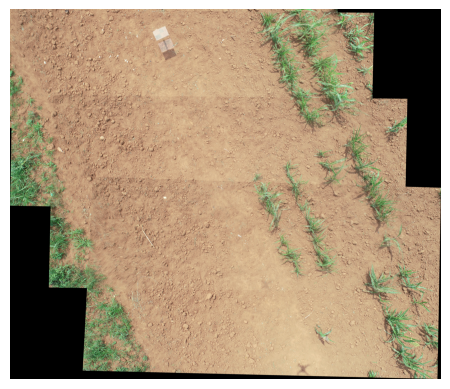

In [3]:
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Write the panorama as a png file

In [6]:
# Save the final panorama
cv2.imwrite('../output/stitched_panorama_kaziga1_subsample.png', panorama)

True

### Debug

In [8]:
import os
import re
import yaml
import glob
import torch

def extract_timestamp(filename):
    """Extract the timestamp from the filename assuming it is a number before the file extension."""
    basename = os.path.basename(filename)
    # Use regex to find the last sequence of digits before the file extension
    match = re.search(r'(\d+)(?=\.\w+$)', basename)
    if match:
        return int(match.group(1))
    return None

def load_config(config_path):
    """Load configuration from a YAML file and compile regex patterns."""
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)

    # Adjust device setting based on the string from config
    config["device"] = torch.device(config["device"] if torch.cuda.is_available() and config["device"] == "cuda" else "cpu")
    print("Configuration loaded successfully.")
    return config

def get_image_paths(config):
    """Get sorted image paths based on timestamps from filenames."""
    all_image_files = glob.glob(os.path.join(config["image_directory"], '*.*'))  # Adjust the pattern to include all files
    image_files_with_timestamps = []

    for filepath in all_image_files:
        timestamp = extract_timestamp(filepath)
        if timestamp is not None:
            image_files_with_timestamps.append((timestamp, filepath))
        else:
            print(f"Filename {filepath} does not contain a valid timestamp and will be skipped.")

    # Sort the image files based on timestamp
    image_files_with_timestamps.sort(key=lambda x: x[0])
    print(f"Found {len(image_files_with_timestamps)} images to process.")
    return [filepath for _, filepath in image_files_with_timestamps]

    # Sort the image files based on timestamp
    image_files_with_timestamps.sort(key=lambda x: x[0])
    return [filepath for _, filepath in image_files_with_timestamps]

In [9]:
config = load_config("config.yaml")
image_paths = get_image_paths(config)

print("Processing images...")
total_images = len(image_paths)
processed_count = 0

original_images = []
original_sizes = []
feats_list = []

Configuration loaded successfully.
Found 8 images to process.
Processing images...


In [10]:
from torchvision import transforms
from lightglue.utils import rbd
from lightglue import LightGlue, SuperPoint, ALIKED

def process_image(path, config):
    """Load, crop, resize, and extract features from an image."""
    image_cv = cv2.imread(path)
    print(f"Processing image: {path}")
    if image_cv is None:
        print(f"Error loading image {path}")
        return None, None, None

    # Crop image
    h, w = image_cv.shape[:2]
    image_cropped = image_cv[config["top_crop"]:h - config["bottom_crop"], config["left_crop"]:w - config["right_crop"]]

    # Update size after cropping
    h_cropped, w_cropped = image_cropped.shape[:2]

    # Convert cropped image to tensor
    image_tensor = transforms.ToTensor()(image_cropped).to(config["device"]).unsqueeze(0)

    # Resize image for feature extraction
    image_resized = cv2.resize(image_cropped, (config["fixed_width"], config["fixed_height"]), interpolation=cv2.INTER_LINEAR)
    image_resized_tensor = transforms.ToTensor()(image_resized).to(config["device"]).unsqueeze(0)

    # Extract features
    if config['extractor'] == 'superpoint':
        print('Using SuperPoint for feature extraction')
        extractor = SuperPoint(max_num_keypoints=2048).eval().to(config["device"])
    if config['extractor'] == 'aliked':
        print('Using ALIKED for feature extraction')
        extractor = ALIKED(max_num_keypoints=2048).eval().to(config["device"])

    with torch.no_grad():
        feats = extractor.extract(image_resized_tensor)
        feats['keypoints'] = feats['keypoints'].unsqueeze(0)
        feats['descriptors'] = feats['descriptors'].unsqueeze(0)
        feats['scores'] = feats.get('scores', torch.ones((1, feats['keypoints'].shape[1]), device=feats['keypoints'].device))
        feats = rbd(feats)

    print(f"Extracted features from image: {path}")
    return image_tensor, (h_cropped, w_cropped), feats

In [11]:
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor() as executor:
    results = executor.map(lambda path: process_image(path, config), image_paths)

Processing image: ../data/marcci-sorghum-subset/DJI_0005.JPG
Processing image: ../data/marcci-sorghum-subset/DJI_0007.JPG
Processing image: ../data/marcci-sorghum-subset/DJI_0006.JPG
Processing image: ../data/marcci-sorghum-subset/DJI_0004.JPG
Processing image: ../data/marcci-sorghum-subset/DJI_0003.JPG
Processing image: ../data/marcci-sorghum-subset/DJI_0009.JPG
Processing image: ../data/marcci-sorghum-subset/DJI_0010.JPG
Processing image: ../data/marcci-sorghum-subset/DJI_0008.JPG
Using SuperPoint for feature extraction
Using SuperPoint for feature extraction
Using SuperPoint for feature extraction
Using SuperPoint for feature extraction
Using SuperPoint for feature extraction
Using SuperPoint for feature extraction
Using SuperPoint for feature extraction
Using SuperPoint for feature extraction
Extracted features from image: ../data/marcci-sorghum-subset/DJI_0006.JPG
Extracted features from image: ../data/marcci-sorghum-subset/DJI_0009.JPG
Extracted features from image: ../data/marcc

In [12]:
%matplotlib inline

In [13]:
for image_tensor, size, feats in results:
    processed_count += 1
    print(f"Processed {processed_count}/{total_images} images.")
    if image_tensor is not None:
        original_images.append(image_tensor)
        original_sizes.append(size)
        feats_list.append(feats)

Processed 1/8 images.
Processed 2/8 images.
Processed 3/8 images.
Processed 4/8 images.
Processed 5/8 images.
Processed 6/8 images.
Processed 7/8 images.
Processed 8/8 images.


In [21]:
feats_list[0]['scores'].squeeze().shape

torch.Size([])

In [23]:
import torch

# Set the threshold for filtering keypoints
keypoint_score_threshold = 0.3  # You can change this value as needed

# Assuming feats_list contains the features extracted for each image
filtered_feats_list = []

for feats in feats_list:
    # Extract original values
    keypoints = feats['keypoints'].squeeze()  # Shape: (num_keypoints, 2)
    keypoint_scores = feats['keypoint_scores'].squeeze()  # Shape: (num_keypoints,)
    descriptors = feats['descriptors'].squeeze()  # Shape: (num_keypoints, descriptor_dim)

    # Identify keypoints with score greater than the threshold
    valid_indices = torch.where(keypoint_scores > keypoint_score_threshold)[0]

    # Filter keypoints, descriptors, and scores based on valid indices
    filtered_keypoints = keypoints[valid_indices, :]  # Shape: (valid_num_keypoints, 2)
    filtered_descriptors = descriptors[valid_indices, :]  # Shape: (valid_num_keypoints, descriptor_dim)
    filtered_keypoint_scores = keypoint_scores[valid_indices]  # Shape: (valid_num_keypoints,)

    # Create a new dictionary with filtered values
    filtered_feats = {
        'keypoints': filtered_keypoints.unsqueeze(0),  # Adding back batch dimension
        'keypoint_scores': filtered_keypoint_scores.unsqueeze(0),
        'descriptors': filtered_descriptors.unsqueeze(0),
        'scores': feats['scores'],
        'image_size': feats['image_size']
    }

    # Append the filtered features to the list
    filtered_feats_list.append(filtered_feats)

# Now `filtered_feats_list` contains only the keypoints, descriptors, and scores with scores above the threshold


In [25]:
filtered_feats_list[0]['keypoints'].shape

torch.Size([1, 262, 2])

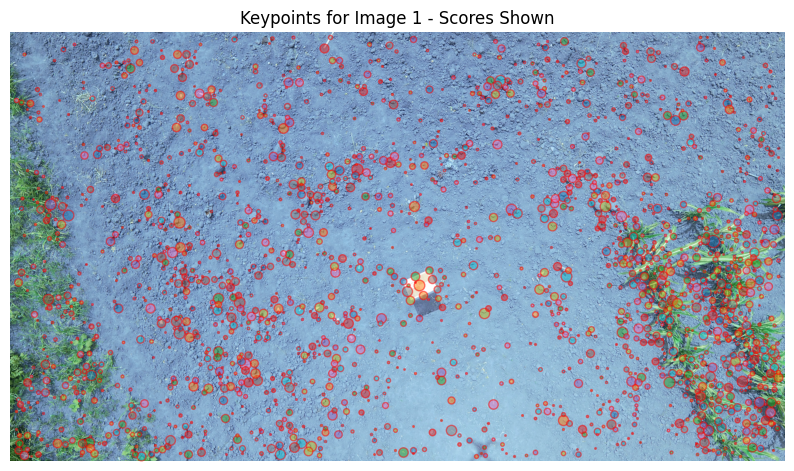

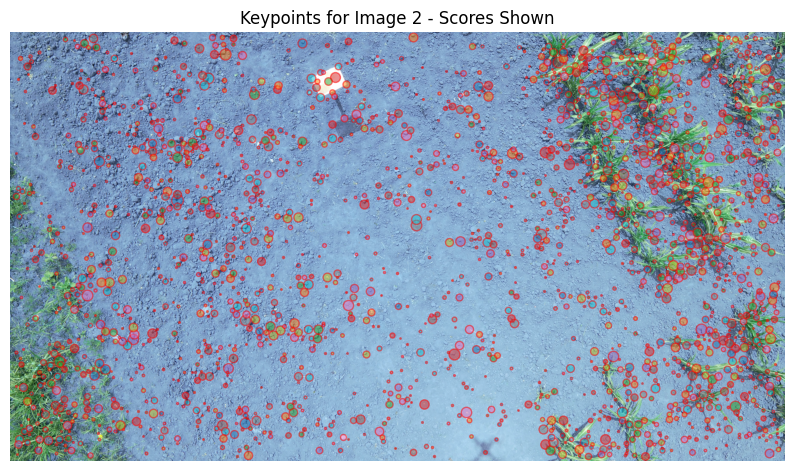

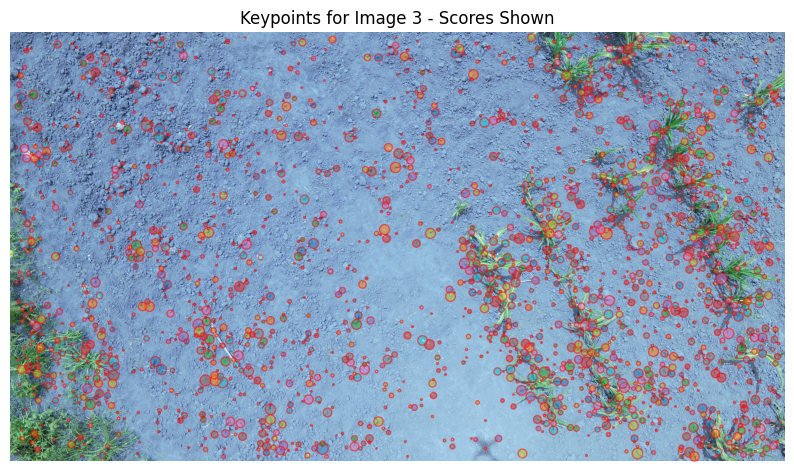

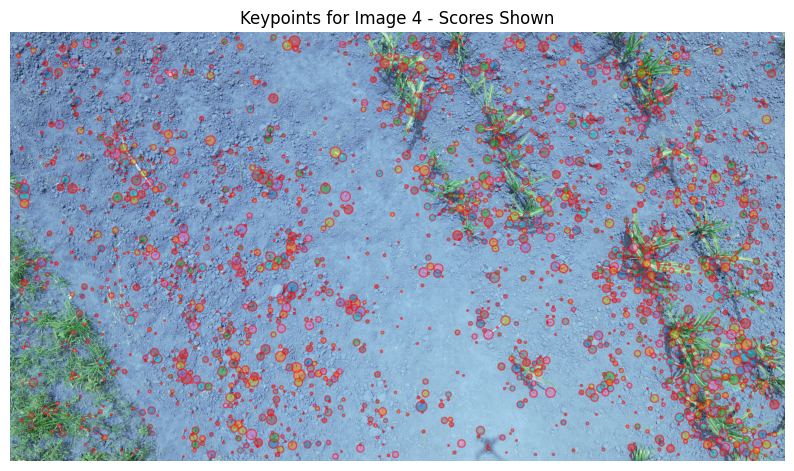

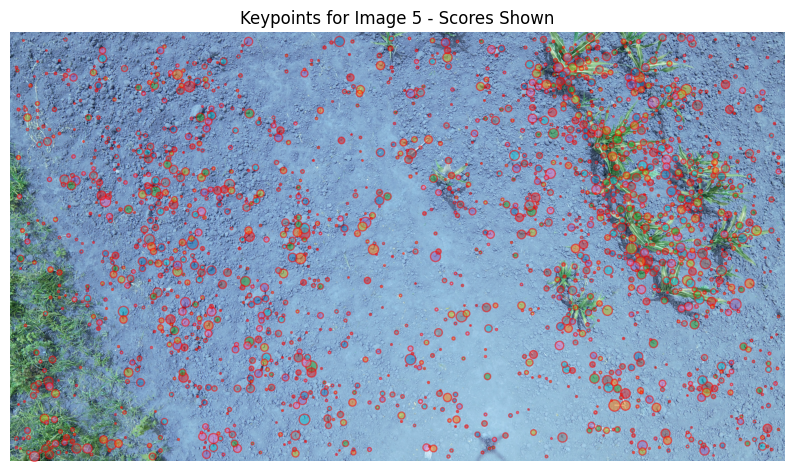

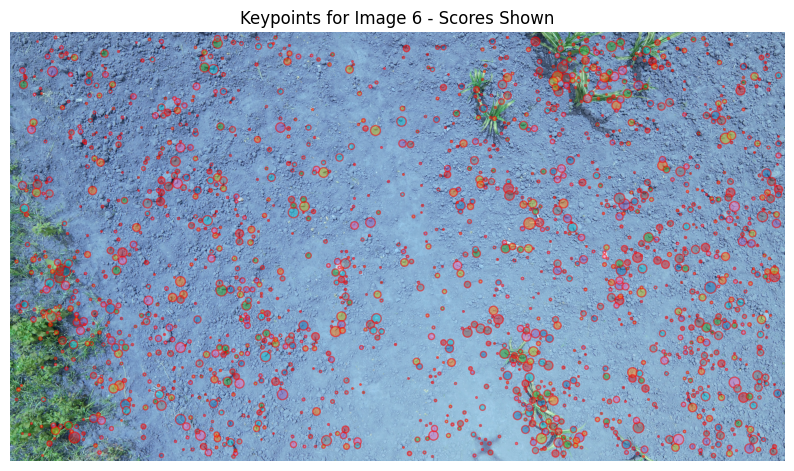

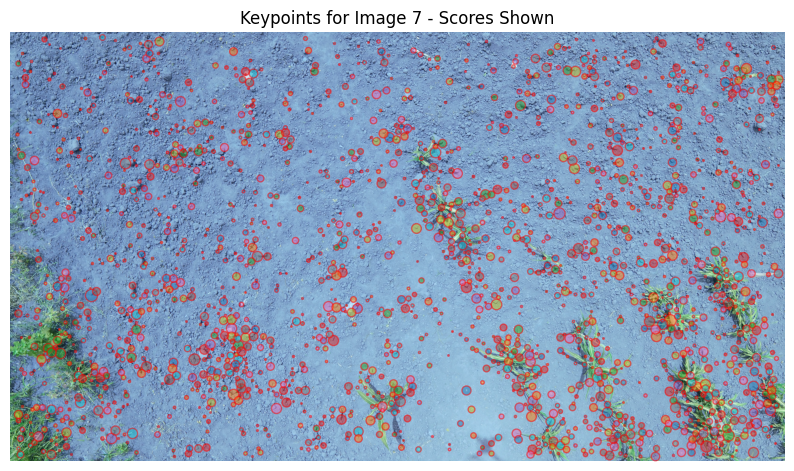

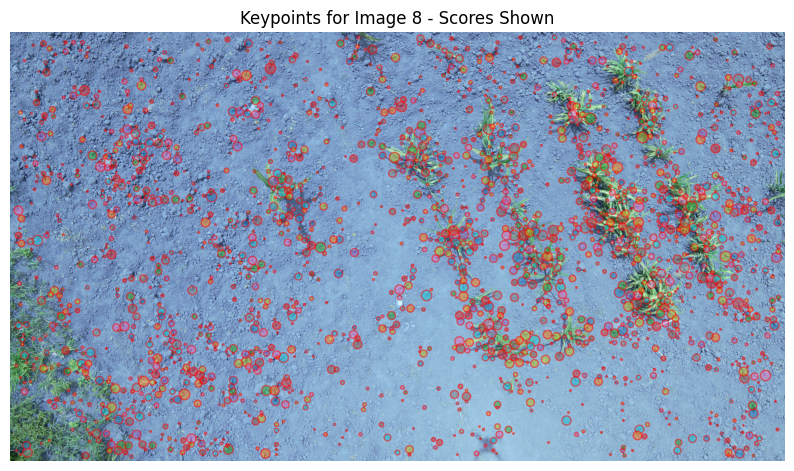

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

# Assuming original_images and feats_list are populated from the previous loop
for idx, (image_tensor, feats, (h_cropped, w_cropped)) in enumerate(zip(original_images, feats_list, original_sizes)):
    # Convert the image tensor to numpy and reshape for plotting
    img_np = image_tensor.squeeze().cpu().numpy()
    if img_np.shape[0] == 3:  # RGB image
        img_np = img_np.transpose(1, 2, 0)  # Make it (H, W, 3)

    # Extract keypoints and scores
    keypoints_resized = feats['keypoints'].squeeze().cpu().numpy()  # Shape: (2, num_keypoints)
    keypoint_scores = feats['keypoint_scores'].squeeze().cpu().numpy()  # Shape: (num_keypoints,)

    # Resizing factors
    scale_x = w_cropped / config['fixed_width']
    scale_y = h_cropped / config['fixed_height']

    # Convert keypoints from resized to cropped coordinates
    keypoints_cropped = keypoints_resized.copy()
    keypoints_cropped[:, 0] *= scale_x
    keypoints_cropped[:, 1] *= scale_y

    # Create figure for plotting
    plt.figure(figsize=(10, 10))
    plt.imshow(img_np)

    # Plot the keypoints if they exist
    if keypoints_cropped.shape[0] > 0:  # Check if there are keypoints to plot
        for i in range(keypoints_cropped.shape[0]):
            if keypoint_scores[i] > 0.01:  # Only plot keypoints with score > 0.3
                plt.scatter(keypoints_cropped[i, 0], keypoints_cropped[i, 1], 
                            s=keypoint_scores[i] * 100, edgecolor='red', alpha=0.5)

    plt.title(f'Keypoints for Image {idx + 1} - Scores Shown')
    plt.axis('off')
    plt.show()
    plt.pause(0.001)


In [29]:
import matplotlib.pyplot as plt
sum(feats_list[2]['keypoint_scores'] > 0.3)

tensor(262)